<a href="https://colab.research.google.com/github/MelihKlc/Deep-Learning/blob/main/Transfer_learning_Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Transfer learning with fine-tuning

In [1]:
# We use script for all helper function.
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-08-09 15:47:39--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.3’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-08-09 15:47:39 (77.0 MB/s) - ‘helper_functions.py.3’ saved [10246/10246]



In [2]:
 # Import helper functions we are going to use in this notebook
 from helper_functions import create_tensorboard_callback , plot_loss_curves , unzip_data , walk_through_dir

# Lets get some data

This time we are going to see how we can use the pretrained models within tf.keras.applications and then apply them to our own problem (recognizing images of food)
link : https://www.tensorflow.org/api_docs/python/tf/keras/applications


In [3]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2023-08-09 15:47:46--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.126.128, 74.125.70.128, 74.125.132.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.126.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.3’

10_food_classes_10_ 100%[===================>] 160.74M  99.4MB/s    in 1.6s    

2023-08-09 15:47:48 (99.4 MB/s) - ‘10_food_classes_10_percent.zip.3’ saved [168546183/168546183]



In [4]:
unzip_data("10_food_classes_10_percent.zip")

In [5]:
#Lets check out how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [6]:
# Create training and test directory path
train_dir = "/content/10_food_classes_10_percent/train"
test_dir = "/content/10_food_classes_10_percent/test"

#We will use different class. This class is faster than ImageDataGenerator. Yani bu sefer datagen olusturmamıza gerek olmayacak direkt bu fonksiyonun icinde halledicez hepsini.
import tensorflow as tf
train_data = tf.keras.preprocessing.image_dataset_from_directory(directory = train_dir ,
                                                                 batch_size = 32 ,
                                                                 image_size = (224,224) ,
                                                                 label_mode = "categorical"
                                                                 )
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory = test_dir ,
                                                                batch_size = 32 ,
                                                                image_size = (224,224) ,
                                                                label_mode = "categorical"
                                                                )

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [7]:
train_data  #Batch dataset olarak geldi tensor. None kısmı aslında batch size. 10 classes

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [8]:
# Check out the classnames our dataset
train_data.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [9]:
# See an example of a batch of data
for images , labels in train_data.take(1): #take bizim batchimizi unravel(çözmek) etmemizi sağlıyor. Girdiğimiz 1 de 1 batch al demek
  print(images , labels)

tf.Tensor(
[[[[9.00000000e+00 6.00000000e+00 2.57142849e+01]
   [6.71428537e+00 4.64285707e+00 1.89999981e+01]
   [4.58163261e+00 3.58163261e+00 1.11530609e+01]
   ...
   [9.05103607e+01 5.97297211e+01 5.13724480e+01]
   [8.77601700e+01 5.78112183e+01 4.41428452e+01]
   [7.59696579e+01 4.79697266e+01 3.59696922e+01]]

  [[6.76020384e+00 5.40306091e+00 2.44744892e+01]
   [5.00510216e+00 4.00510216e+00 1.81581631e+01]
   [9.35714340e+00 8.35714340e+00 1.59285717e+01]
   ...
   [7.37246017e+01 5.03367653e+01 3.90662880e+01]
   [8.04999466e+01 5.92907906e+01 4.24285431e+01]
   [7.10256500e+01 5.36225929e+01 3.77654495e+01]]

  [[1.16326532e+01 1.06326532e+01 2.86326523e+01]
   [3.19897890e+00 2.19897890e+00 1.63418350e+01]
   [4.40306091e+00 2.95408154e+00 1.31428566e+01]
   ...
   [5.86631050e+01 4.30916328e+01 2.89486885e+01]
   [6.54794846e+01 5.04540100e+01 3.20662498e+01]
   [5.72652397e+01 4.76888084e+01 2.95459156e+01]]

  ...

  [[1.33525497e+02 9.48826981e+01 5.93825493e+01]
   [1

# Model 0 : Building a transfer learning feature extraction model using the Keras functional API

The sequential API is straightforward , it runs our layers in sequential order.

But the functional API gives us more flexibility with our models

In [10]:
# 1. Create a base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top = False)  #Top layer aslında output layer oluyor biz bunu değiştireceğimiz için false yapıyoruz.

# 2. Freeze the base model ( so the underlying pre-trained patterns arent updated)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape = (224,224,3) , name = "input_layer")

# 4. If using resnet50v2 you will need to normalize inputs. But in efficientnetb0 , we dont have to.
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)  eğer normalize yapmamız gerekirse böyle yapıyoruz.

# 5. Pass the inputs to the base model
x = base_model(inputs)  #base model inputlarımızı alıyor bu şekilde
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important informations , reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)  #aslında bu x i sona koydugumuzda yukarda olusturdugumuz x = basemodel kısmını buraya baglamıs oluyoruz.
print(f"Shape after GlobalAveragePooling2D : {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10 , activation = "softmax" , name = "output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs , outputs)

# 9. Compile a model

model_0.compile(loss = ["categorical_crossentropy"] ,
                optimizer = tf.keras.optimizers.Adam() ,
                metrics = ["accuracy"]
                )
# 10. Fit the model

hist_0 = model_0.fit( train_data , epochs = 5 , steps_per_epoch = len(train_data) , validation_data = test_data , validation_steps = int( 0.25 * len(test_data)) , callbacks = [create_tensorboard_callback(dir_name = "transfer_learning" , experiment_name = "10_percent_feature_extractor") ]) # test datanın %25 ini alıyoruz


Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D : (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extractor/20230809-154804


Epoch 1/5
24/24 [==============================] - 16s 249ms/step - loss: 1.9240 - accuracy: 0.3880 - val_loss: 1.3184 - val_accuracy: 0.7599
Epoch 2/5
24/24 [==============================] - 6s 197ms/step - loss: 1.1158 - accuracy: 0.7680 - val_loss: 0.9006 - val_accuracy: 0.8109
Epoch 3/5
24/24 [==============================] - 4s 146ms/step - loss: 0.7977 - accuracy: 0.8307 - val_loss: 0.6940 - val_accuracy: 0.8602
Epoch 4/5
24/24 [==============================] - 6s 220ms/step - loss: 0.6471 - accuracy: 0.8520 - val_loss: 0.5983 - val_accuracy: 0.8734
Epoch 5/5
24/24 [==============================] - 4s 150ms/step - loss: 0.5563 - accuracy: 0.8747 - val_loss: 0.5403 - val_accuracy: 0.8750


In [11]:
# Evaluate on the full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 8s 90ms/step - loss: 0.5628 - accuracy: 0.8600


[0.5628222227096558, 0.8600000143051147]

In [12]:
# Check the layers our base model
for layer_number , layer in enumerate(base_model.layers):
  print(layer_number , layer.name)

0 input_1
1 rescaling
2 normalization
3 rescaling_1
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activation
5

In [13]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [14]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


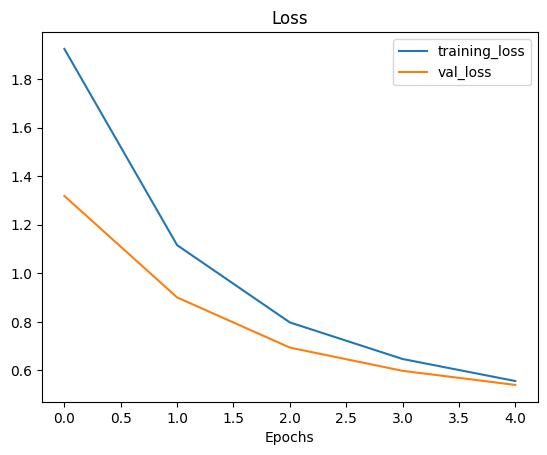

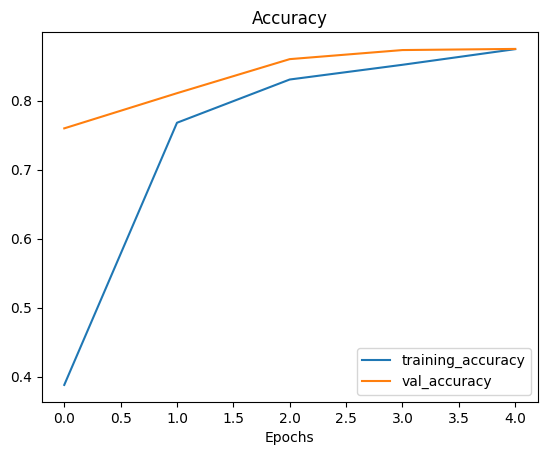

In [15]:
plot_loss_curves(hist_0)

# Getting a feature vector from a trained model   ( (None , 1280) aslında bu bizim feature vectorumuz. None kısmı batch size )

Lets get the global average pooling 2d layer

We have a tensor after our model goes through 'base_model' of shape (None , 7 , 7 , 1280).

But then , when it passes through GlobalAveragePooling2D , it turns into (None , 1280).

Lets use a similar shaped tensor of (1 , 4 , 4 , 3) and then pass it to GlobalAveragePooling2D

In [16]:
# Define the input shape
input_shape = ( 1 , 4 , 4 , 3 )
import tensorflow as tf

# Create a random tensor with input_shape
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)  #For creating random tensor
print(f"Random input tensor : \n {input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor : \n {global_average_pooled_tensor} \n")

# Check the shapes of different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of the global average pooled tensor: {global_average_pooled_tensor.shape}")

Random input tensor : 
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor : 
 [[-0.09368646 -0.45840448 -0.2885598 ]] 

Shape of input tensor: (1, 4, 4, 3)
Shape of the global average pooled tensor: (1, 3)


In [17]:
 # Lets replicate the GlobalAveragePool2D layer
 tf.reduce_mean(input_tensor , axis = [1,2])  # Aslında global average pooling layer bunu yapıyor. axis 1 , 2 dediğimiz ortadaki 2 dimensionun indexleri. ortadaki 2 dimension ın average ını alıp information kaybetmeden yeni 2 dimensional feature vectoru oluşturuyo

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

# One of the reasons feature extraction transfer learning is named how it is because what often happens is pre-trained model outputs a feature vector (a long tensor of numbers which represents the learned representation of the model on a particular sample, in our case , this is the output of GlobalAveragePooling2D layer) which can then be used to extract patterns out of for our own spesific problem.  

In [18]:
# Lets do it same process with GlobalMaxPool2D

global_max_pooled_tensor = tf.keras.layers.GlobalMaxPool2D()(input_tensor)
global_max_pooled_tensor

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.9058464, 1.1603122, 1.6994323]], dtype=float32)>

# Feature vector aslında bizim en son outputa verdiğimiz şey. outputun inputu yani. Feature vector de pooling layer ın outputu.  Bizim bütün conv gibi layerlarımızın çıktısı büyük bir vector oluyor ve bu belli bir pattern öğrenmiş oluyor. Bu patternı condense edip en önemli bilgileri içinden alıyoruz ve küçük bir vektör haline getiriyoruz pooling layer ile.

# Running a series of transfer learning experiments

We have only seen the incredible results transfer learning can get with only %10 percent of the training data , but how does it go with %1 percent of the training data? How about we set up a bunch of experiments to find out;

1. 'model_1' - use feature extraction transfer learning with %1 percent of the training data with data augmentation.
2. 'model_2' - use feature extraction transfer learning with %10 of the training data with data augmentation.
3. 'model_3' - use fine-tuning transfer learning on %10 of the training data with data augmentation.
4. 'model_4' - use fine-tuning transfer learning on %100 of the training data with data augmentation.

> Note : throughout all experiments the same test dataset will be used to evaluate our model. this ensures consistency across evaluation metrics.

# We start with model_1

In [19]:
# Download and unzip function.
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

--2023-08-09 15:48:54--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.120.128, 142.250.103.128, 142.251.171.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.120.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip.2’

10_food_classes_1_p 100%[===================>] 127.42M  42.1MB/s    in 3.0s    

2023-08-09 15:48:57 (42.1 MB/s) - ‘10_food_classes_1_percent.zip.2’ saved [133612354/133612354]



In [20]:
# Create train and test directory.
train_dir_1_percent = "/content/10_food_classes_1_percent/train"
test_dir = "/content/10_food_classes_1_percent/test"


In [21]:
# How many images we are working with?
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There a

In [22]:
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(directory = train_dir_1_percent ,
                                                                           batch_size = 32 ,
                                                                           image_size = (224,224) ,
                                                                           label_mode = "categorical"
                                                                           )
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory = test_dir ,
                                                                batch_size = 32 ,
                                                                image_size = (224,224) ,
                                                                label_mode = "categorical"
                                                                )

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


# Adding data augmentation right into the model

To add data augmentation right into our models , we can use the layer inside:

> tf.keras.layers.experimental.preprocessing()

In [23]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation stage with horizontal flipping , rotations , zooms , etc
# Biz modelimizi oluştururken Keras API kullansak da data augmentation yaparken sequential API kullanıyoruz.

data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal") ,
    preprocessing.RandomRotation(0.2) ,
    preprocessing.RandomZoom(0.2) ,
    preprocessing.RandomHeight(0.2) ,
    preprocessing.RandomWidth(0.2)
    #preprocessing.Rescale(1./255)  bunu resnet50v2 gibi kendi içinde rescale içermeyenlerde kullanıyoruz. Şu an efficient net kullanıyoruz ve bu modelde rescale zaten yapılmış halde oldugu icin yorum satırı olarak bırakıyoruz.

] , name = "data_augmentation")



# Off the top our of heads , the benefits of using data augmentation inside the model are:
* Preprocessing of images (augmenting them) , happens on the GPU (much faster) , rather than CPU
* Image data augmentation only happens during training , so we can still export our whole model and use it elsewhere

(-0.5, 506.5, 429.5, -0.5)

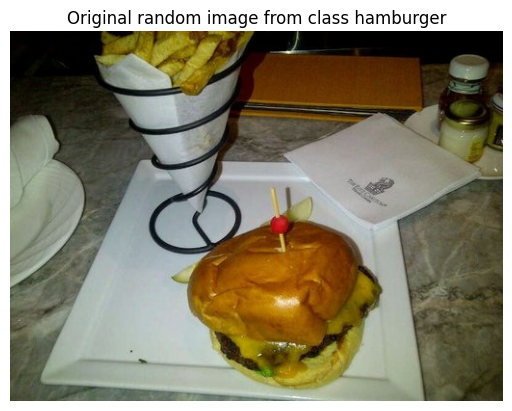

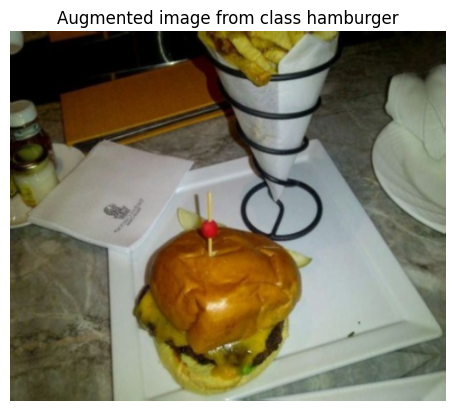

In [24]:
# View the random image and compare it with the augmented version

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))   #os.listdir(target_dir): Belirtilen dizindeki tüm dosya ve klasörlerin listesini alır. target_dir değişkeni, bu işlemi yapılacak olan dizini temsil eder.
random_image_path = target_dir + "/" + random_image

# Read and plot the random image

img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class {target_class}")
plt.axis(False)

# Plot augmented random image
augmented_image = data_augmentation(tf.expand_dims(img , axis = 0) , training = True)
plt.figure()
plt.imshow(tf.squeeze(augmented_image)/255.)
plt.title(f"Augmented image from class {target_class}")
plt.axis(False)



# Lets create model_1 with data augmentation

In [25]:
# Create a model_1
base_model_1 = tf.keras.applications.EfficientNetB0(include_top = False)

base_model_1.trainable = False

inputs = tf.keras.layers.Input(shape = (224,224,3) , name = "Input_layer")

# Add in data augmentation sequential model as a layer
x = data_augmentation(inputs)

# Give base_model_1 the inputs (after augmentation) and dont train it
x = base_model_1(x , training = False )

#Eğer elimizde bütün model varsa direkt içine yazıyoruz base_model_1(x  , training=False ) gibi. Eğer elimizde tek bir layer varsa x = tf.keras.layers.GlobalAveragePooling2D(name = "Global_average_pooling_layer")(x) böyle x i en son ayrı parantezlerd yazıyoruz.

x = tf.keras.layers.GlobalAveragePooling2D(name = "Global_average_pooling_layer")(x)

outputs = tf.keras.layers.Dense(10 , activation = "softmax" , name = "output_layer")(x)

model_1 = tf.keras.Model(inputs,outputs)

#Compile model

model_1.compile(loss = ["categorical_crossentropy"] ,
                optimizer = tf.keras.optimizers.Adam() ,
                metrics = ["accuracy"]
                )

#Fit the model

hist_1 = model_1.fit(train_data_1_percent , epochs = 5 , steps_per_epoch = len(train_data_1_percent) , validation_data = test_data , validation_steps = len(test_data))

Epoch 1/5
3/3 [==============================] - 16s 4s/step - loss: 2.2815 - accuracy: 0.2286 - val_loss: 2.1925 - val_accuracy: 0.1964
Epoch 2/5
3/3 [==============================] - 10s 5s/step - loss: 2.0469 - accuracy: 0.3143 - val_loss: 2.0598 - val_accuracy: 0.2912
Epoch 3/5
3/3 [==============================] - 8s 4s/step - loss: 1.8507 - accuracy: 0.4571 - val_loss: 1.9481 - val_accuracy: 0.3732
Epoch 4/5
3/3 [==============================] - 12s 6s/step - loss: 1.6290 - accuracy: 0.6714 - val_loss: 1.8493 - val_accuracy: 0.4408
Epoch 5/5
3/3 [==============================] - 12s 6s/step - loss: 1.5639 - accuracy: 0.6286 - val_loss: 1.7601 - val_accuracy: 0.4828


In [26]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 Global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

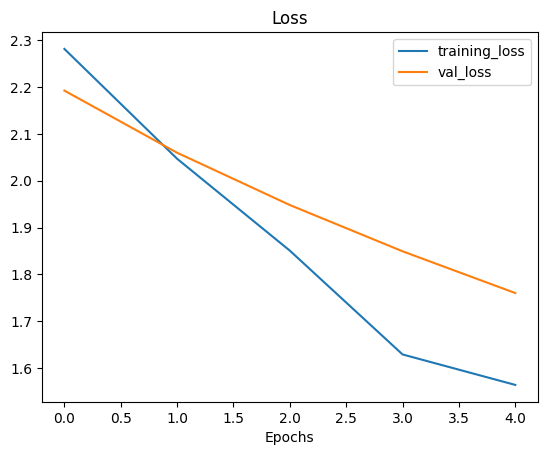

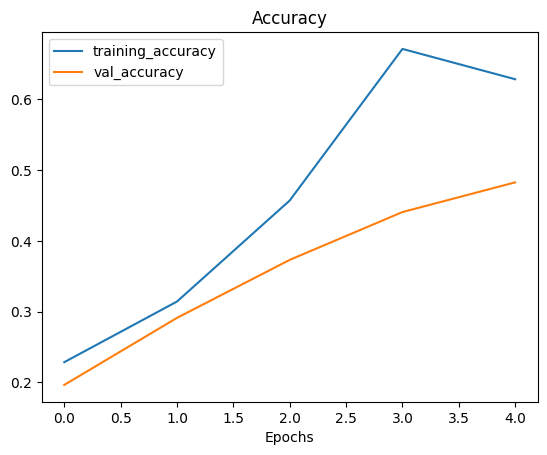

In [27]:
# Visualize loss curve
plot_loss_curves(hist_1)

In [28]:
# Create model_2 with data augmentation and 10 percent of data
train_dir_model_2 = "/content/10_food_classes_10_percent/train"
test_dir_model_2 = "/content/10_food_classes_10_percent/test"

train_data_model_2 = tf.keras.preprocessing.image_dataset_from_directory(directory = train_dir_model_2 ,
                                                                         batch_size = 32 ,
                                                                         image_size = (224,224) ,
                                                                         label_mode = "categorical"
                                                                         )
test_data_model_2 = tf.keras.preprocessing.image_dataset_from_directory(directory = test_dir_model_2 ,
                                                                         batch_size = 32 ,
                                                                         image_size = (224,224) ,
                                                                         label_mode = "categorical"
                                                                         )


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [29]:
data_augmentation_2 = tf.keras.Sequential([
    preprocessing.RandomFlip("horizontal") ,
    preprocessing.RandomRotation(0.2) ,
    preprocessing.RandomZoom(0.2) ,
    preprocessing.RandomHeight(0.2) ,
    preprocessing.RandomWidth(0.2)


] , name = "data_augmentation")

In [30]:
base_model_2 = tf.keras.applications.EfficientNetB0(include_top = False)

base_model_2.trainable = False

inputs = tf.keras.layers.Input(shape = (224,224,3) , name = "input_layer")

x = data_augmentation(inputs)

x = base_model_2(x , training = False) # pass augmented images to base model but keep it in inference mode, so batchnorm layers don't get updated.

x = tf.keras.layers.GlobalAveragePooling2D()(x)

outputs = tf.keras.layers.Dense(10 , activation = "softmax" , name = "output_layer")(x)

model_2 = tf.keras.Model(inputs , outputs)

#compile

model_2.compile(loss = ["categorical_crossentropy"] ,
                optimizer = tf.keras.optimizers.Adam() ,
                metrics =  ["accuracy"]
                )



# Creating a model checkpoint
The ModelCheckpoint callback intermediately saves our model (the full model or just weights) during training. This is useful so we can come and start where we left off

In [31]:
# Set the checkpoint path
checkpoint_path = "ten_percent_model_checkpoint_weights/checkpoint.ckpt"

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_path ,
    save_weights_only = True ,
    save_best_only = False ,
    save_freq = "epoch"  ,# save every epoch
    verbose = 1
 )
initial_epochs = 5

In [32]:
hist_2 = model_2.fit(train_data_model_2 , epochs = initial_epochs , steps_per_epoch = len(train_data_model_2) , validation_data = test_data_model_2 , validation_steps = len(test_data_model_2) ,  callbacks = [create_tensorboard_callback(dir_name = "transfer_learning" , experiment_name = "10_percent_data_aug") , checkpoint_callback] )

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20230809-155018
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.9180 - accuracy: 0.3813
Epoch 1: saving model to ten_percent_model_checkpoint_weights/checkpoint.ckpt
24/24 [==============================] - 28s 844ms/step - loss: 1.9180 - accuracy: 0.3813 - val_loss: 1.3856 - val_accuracy: 0.6780
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.2707 - accuracy: 0.7120
Epoch 2: saving model to ten_percent_model_checkpoint_weights/checkpoint.ckpt
24/24 [==============================] - 17s 711ms/step - loss: 1.2707 - accuracy: 0.7120 - val_loss: 0.9487 - val_accuracy: 0.7956
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.9734 - accuracy: 0.7880
Epoch 3: saving model to ten_percent_model_checkpoint_weights/checkpoint.ckpt
24/24 [==============================] - 16s 653ms/step - loss: 0.9734 - accuracy: 0.7880 - val_loss: 0.7652 - val_accuracy: 0.8220
Epoc

In [33]:
model_0.evaluate(test_data)

79/79 [==============================] - 7s 71ms/step - loss: 0.5628 - accuracy: 0.8600


[0.562822163105011, 0.8600000143051147]

In [34]:
results_base = model_2.evaluate(test_data_model_2)

79/79 [==============================] - 8s 88ms/step - loss: 0.6083 - accuracy: 0.8408


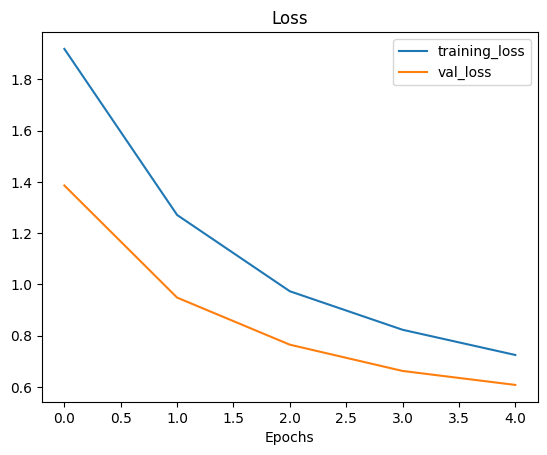

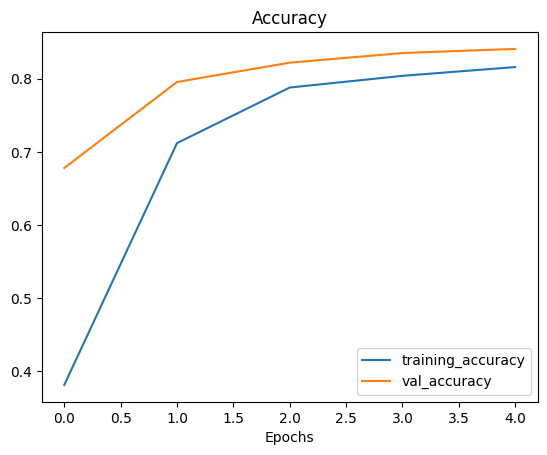

In [35]:
plot_loss_curves(hist_2)

 # Loading in checkpointed weights

 Loading in checkpointed weights returns a model to a spesific checkpoint

In [36]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [37]:
# Evaluate model with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data_model_2)

79/79 [==============================] - 6s 70ms/step - loss: 0.6083 - accuracy: 0.8408


# If the results from our previously evaluated model_2 match the loaded weights, everything has worked
# Eğer aynı sonucları alamazsak precision yüzünden oluyor. Yani aslında çok çok küçük farklar nedeniyle loss functiondaki sonuc aynı cıkmıyor.


In [38]:
# Check to see if loaded model results are very close to our previous non loaded model results
import numpy as np
np.isclose(np.array(results_base) , np.array(loaded_weights_model_results))

array([ True,  True])

In [39]:
# Check the difference between the two results
print(np.array(results_base) - np.array(loaded_weights_model_results))

[1.1920929e-07 0.0000000e+00]


# Lets create model_3 , 10 percent of data , with data augmentation , with FINE TUNING

Fine tuning uygularken output layera yakın olan layerları unfreeze ediyoruz genelde çünkü ilk layerlar daha büyük image size lara bakıyor. Yani aslında ilk layerlar learn more general features. Bu yüzden son layerları unfreeze edip weights lerini uptade etmek bizim için daha iyi oluyor.

> **Note :** Fine tuning usually works best after training a feature extraction model for a few epochs with large amounts of custom data

# Yani biz aslında yukarda trainable modelimizin weightslerini uptade etmiştik. Bunu aslında fine tuningte kullanmak icin yaptık (model_2.load_weights)

In [40]:
# Our layers and are they trainable or not?
for layer in model_2.layers:
  print(layer , layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x79d3797bbee0> True
<keras.engine.sequential.Sequential object at 0x79d37ee38850> True
<keras.engine.functional.Functional object at 0x79d379485a50> False
<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x79d3797bbf40> True
<keras.layers.core.dense.Dense object at 0x79d379503940> True


In [41]:
# What layer are in our base_model (EfficientnetB0) and are they trainable?
for layer_number, layer in enumerate(base_model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_4 False
2 normalization_2 False
3 rescaling_5 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

# To begin fine-tuning, we'll unfreeze the entire base model by setting its trainable attribute to True. Then we'll refreeze every layer in the base model except for the last 10 by looping through them and setting their trainable attribute to False. Finally, we'll recompile the model.

In [42]:
base_model_2.trainable = True  # Now all of layers are trainable

# And now we will set all of layers untrainable (freeze) except last 10 layers

for layer in base_model_2.layers[ : -10]:  #-10 means we wont deliver last 10 layers (sondan belli sayıda layer dahil etmek istemiyosak -10 gibi kullanıyoruz yani sondan 10 layer dahil değil şu an for loopa)
  layer.trainable = False

# Recompile ( We have to recompile our models every time we make a change )
# Recompile ettiğimizde modelin içine o zaman girip bakıyor bilgisayar ve yaptıgımız degisiklikleri uptade ediyor.

model_2.compile(loss = ["categorical_crossentropy"] ,
                optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001) ,  # When fine-tuning , you typically want to lower the learning rate by 10x
                metrics = ["accuracy"]
                )




# **Note:** When using fine-tuning , it's best practice to lower your learning rate by some amount. How much? This is a hyperparameter you can tune. But a good rule of thumb is at least 10x

Learning rate i azaltmamız gerekiyor çünkü zaten pre-learned bi pattern var elimizde eğer bunun üstüne learning rate de yüksek tutarsak overfitting oluruz.

In [43]:
# Check which layers are tunable(trainable)
for layer_number, layer in enumerate(base_model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_4 False
2 normalization_2 False
3 rescaling_5 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [44]:
# Now we have unfrozen some of the layers closer to the top , how many trainable variables are there?

print(len(model_2.trainable_variables))

12


In [45]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2

hist_fine_tune = model_2.fit(train_data_model_2 , epochs = fine_tune_epochs , steps_per_epoch = len(train_data_model_2) , validation_data = test_data_model_2 , validation_steps = len(test_data_model_2) , initial_epoch = hist_2.epoch[-1] , callbacks = [create_tensorboard_callback(dir_name = "transfer_learning" , experiment_name = "10_percent_data_aug_fine_tune") , checkpoint_callback])
#initial_epoch = hist_2.epoch[-1] means that start training from previous last epoch

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug_fine_tune/20230809-155226


Epoch 5/10
24/24 [==============================] - ETA: 0s - loss: 0.5893 - accuracy: 0.8413
Epoch 5: saving model to ten_percent_model_checkpoint_weights/checkpoint.ckpt
24/24 [==============================] - 29s 796ms/step - loss: 0.5893 - accuracy: 0.8413 - val_loss: 0.4765 - val_accuracy: 0.8492
Epoch 6/10
24/24 [==============================] - ETA: 0s - loss: 0.4732 - accuracy: 0.8520
Epoch 6: saving model to ten_percent_model_checkpoint_weights/checkpoint.ckpt
24/24 [==============================] - 15s 620ms/step - loss: 0.4732 - accuracy: 0.8520 - val_loss: 0.4567 - val_accuracy: 0.8528
Epoch 7/10
24/24 [==============================] - ETA: 0s - loss: 0.4353 - accuracy: 0.8800
Epoch 7: saving model to ten_percent_model_checkpoint_weights/checkpoint.ckpt
24/24 [==============================] - 16s 651ms/step - loss: 0.4353 - accuracy: 0.8800 - val_loss: 0.4331 - val_accuracy: 0.8572
Epoch 8/10
24/24 [==============================] - ETA: 0s - loss: 0.3864 - accuracy: 0

In [46]:
# Evaluate the fine-tuned model ( model_3 which is actually model_2 fine-tuned for another 5 epochs version)
results_fine_tune_10_percent = model_2.evaluate(test_data_model_2)

79/79 [==============================] - 6s 69ms/step - loss: 0.4085 - accuracy: 0.8632


In [47]:
results_base

[0.6083416938781738, 0.8407999873161316]

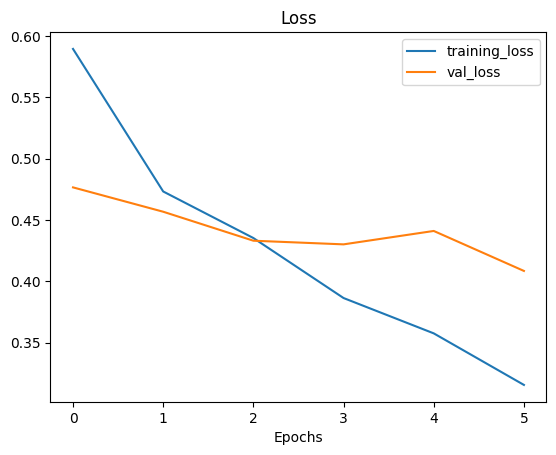

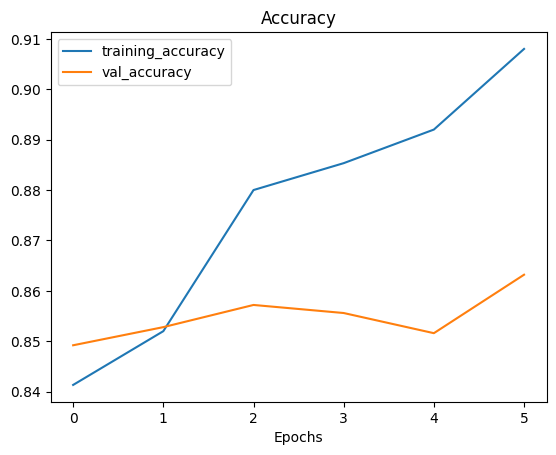

In [48]:
plot_loss_curves(hist_fine_tune)

# The plot_loss_curves functions works great with models which have only been fit once , however , we want something to compare one series of running fit() with another (e.g. before and after fine-tuning )

In [49]:
# Lets create a function to compare training histories

def compare_histories(original_history , new_history , initial_epochs = 5):
  """
  Compares two Tensorflow history objects
  """

  # Get original history measurement

  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]

  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]

  # Combine the original_history metrics with the new_history metrics

  total_acc = acc + new_history.history["accuracy"]
  total_loss = loss + new_history.history["loss"]

  total_val_acc = val_acc + new_history.history["val_accuracy"]
  total_val_loss = val_loss + new_history.history["val_loss"]

  # Make plot

  plt.figure(figsize = (8,8))
  plt.subplot(2 , 1 , 1)
  plt.plot(total_acc , label = "Training Accuracy")
  plt.plot(total_val_acc , label = "Validation Accuracy")
  plt.plot([ initial_epochs-1 , initial_epochs-1 ] , plt.ylim() , label = "Start Fine Tuning" )  #zero index oldugu icin yani 0 dan baslayacagı icin initial epoch-1 dedik
  plt.legend(loc = "lower right")
  plt.title("Training and validation accuracy")

  plt.figure(figsize = (8,8))
  plt.subplot(2 , 1 , 2)
  plt.plot(total_loss , label = "Training Loss")
  plt.plot(total_val_loss , label = "Validation Loss")
  plt.plot([ initial_epochs-1 , initial_epochs-1 ] , plt.ylim() , label = "Start Fine Tuning" )  #zero index oldugu icin yani 0 dan baslayacagı icin initial epoch-1 dedik
  plt.legend(loc = "upper left")
  plt.title("Training and validation loss")





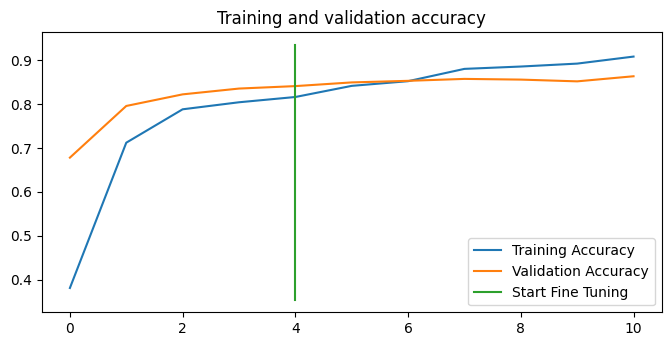

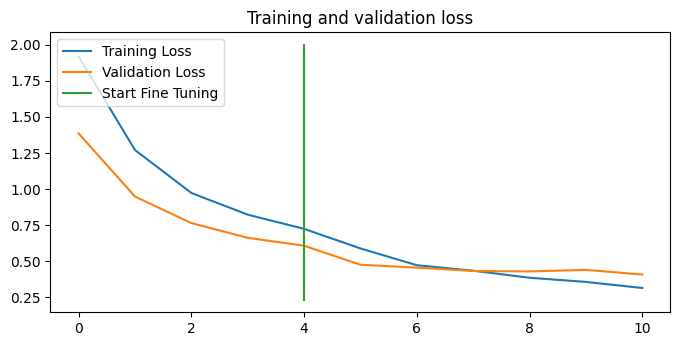

In [50]:
compare_histories( hist_2 , hist_fine_tune)

In [51]:
# Create model_4 (same as with the model_3 but we will use %100 of data)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip


--2023-08-09 15:54:33--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.121.128, 142.250.1.128, 108.177.120.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.121.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip.1’

10_food_classes_all 100%[===================>] 495.13M  76.6MB/s    in 6.0s    

2023-08-09 15:54:39 (82.3 MB/s) - ‘10_food_classes_all_data.zip.1’ saved [519183241/519183241]



In [52]:
unzip_data("10_food_classes_all_data.zip")

In [53]:
train_dir_4 = "/content/10_food_classes_all_data/train"
test_dir_4 = "/content/10_food_classes_all_data/test"


train_data_4 = tf.keras.preprocessing.image_dataset_from_directory(directory = train_dir_4 ,
                                                                   batch_size = 32 ,
                                                                   image_size = (224 , 224) ,
                                                                   label_mode = "categorical"
                                                                   )

test_data_4 = tf.keras.preprocessing.image_dataset_from_directory(directory = test_dir_4 ,
                                                                   batch_size = 32 ,
                                                                   image_size = (224 , 224) ,
                                                                   label_mode = "categorical"
                                                                   )

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


# To train a fine-tuning model ( model_4 ) we need to revert(geri almak) model_2 back to its feature extraction weights.

In [55]:
# Load weights from checkpoint , that way we can fine-tune from the same stage the 10 percent data model was fine-tuned from
model_2.load_weights(checkpoint_path)
# Aslında plot loss curve de 5. epochta çizdiğimiz straight line ın öncesine dönüyoruz tekrardan.

# We have done these;

1. Trained the feature extraction transfer learning model for 5 epochs on %10 of the data with data augmentation (model_2) and we saved the model's weights using ModelCheckpoint callbacks.

2. Fine-tuned the same model on the same %10 of the data for a further 5 epochs with the top 10 layers of the base model unfrozen (model_3).

3. Saved the results and training logs each time.

4. Reloaded the model from step 1 to do the same steps as step 2 except this time we are going to use all of the data (model_4).


In [56]:
base_model_2.trainable = True  # Now all of layers are trainable

# And now we will set all of layers untrainable (freeze) except last 10 layers

for layer in base_model_2.layers[ : -10]:  #-10 means we wont deliver last 10 layers (sondan belli sayıda layer dahil etmek istemiyosak -10 gibi kullanıyoruz yani sondan 10 layer dahil değil şu an for loopa)
  layer.trainable = False

# Recompile ( We have to recompile our models every time we make a change )
# Recompile ettiğimizde modelin içine o zaman girip bakıyor bilgisayar ve yaptıgımız degisiklikleri uptade ediyor.

model_2.compile(loss = ["categorical_crossentropy"] ,
                optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001) ,  # When fine-tuning , you typically want to lower the learning rate by 10x
                metrics = ["accuracy"]
                )

In [57]:
hist_4 = model_2.fit(train_data_4 , epochs = fine_tune_epochs , steps_per_epoch = len(train_data_4) , validation_data =  test_data_4 , validation_steps = len(test_data_4) , initial_epoch= hist_2.epoch[-1] , callbacks = [create_tensorboard_callback(dir_name = "transfer_learning" , experiment_name = "100_percent_data_aug_fine_tune") , checkpoint_callback] )

Saving TensorBoard log files to: transfer_learning/100_percent_data_aug_fine_tune/20230809-162233
Epoch 5/10
235/235 [==============================] - ETA: 0s - loss: 0.3708 - accuracy: 0.8804
Epoch 5: saving model to ten_percent_model_checkpoint_weights/checkpoint.ckpt
235/235 [==============================] - 62s 218ms/step - loss: 0.3708 - accuracy: 0.8804 - val_loss: 0.2740 - val_accuracy: 0.9084
Epoch 6/10
235/235 [==============================] - ETA: 0s - loss: 0.3302 - accuracy: 0.8964
Epoch 6: saving model to ten_percent_model_checkpoint_weights/checkpoint.ckpt
235/235 [==============================] - 47s 197ms/step - loss: 0.3302 - accuracy: 0.8964 - val_loss: 0.2837 - val_accuracy: 0.9052
Epoch 7/10
235/235 [==============================] - ETA: 0s - loss: 0.3111 - accuracy: 0.8980
Epoch 7: saving model to ten_percent_model_checkpoint_weights/checkpoint.ckpt
235/235 [==============================] - 47s 197ms/step - loss: 0.3111 - accuracy: 0.8980 - val_loss: 0.2754 -

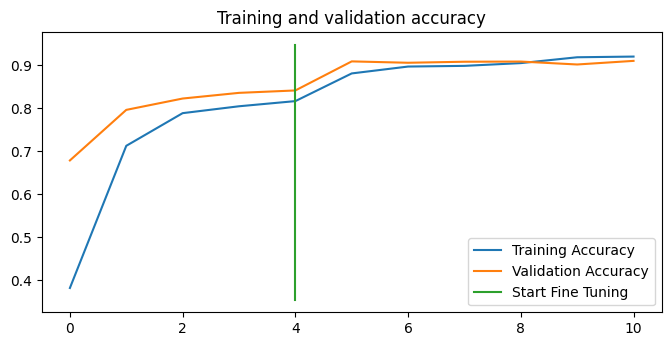

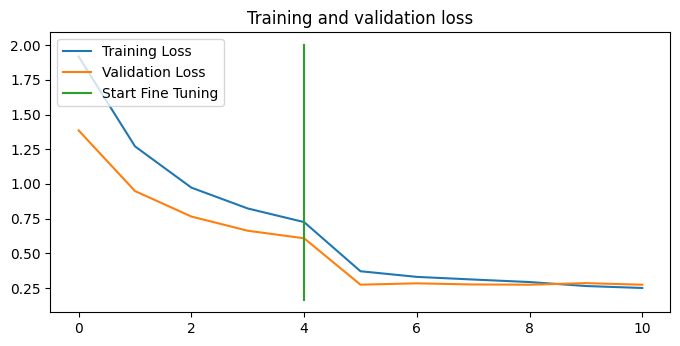

In [58]:
compare_histories(hist_2 , hist_4)